# Learning a Bayesian Network from data about modern F1 races
**Simone Persiani - 00984854** \
**University of Bologna, Master degree in Artificial Intelligence 2020/21**

The present work consists in a deliverable for the exam of "Fundamentals of AI and Knowledge Representation" (module 3).

For more information, please refer to the Project Report document.

## 1. The dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pgmpy.estimators import HillClimbSearch, K2Score, BDeuScore, BayesianEstimator
from pgmpy.models import BayesianModel
from pgmpy.inference import VariableElimination

In [2]:
data = pd.read_csv('dataset.csv',
                   usecols=['SC/VSC stints', 'red_flags', 'weather', 'circuitId',
                            'constructorId', 'grid', 'position', 'rank', 'driver_nationality',
                            'constructor_nationality', 'circuit_country'],
                   dtype={'SC/VSC stints': 'uint8',
                          'red_flags': 'category',
                          'weather': 'category',
                          'circuitId': 'uint16',
                          'constructorId': 'uint16',
                          'grid': 'category',
                          'position': 'category',
                          'rank': 'category',
                          'driver_nationality': 'category',
                          'constructor_nationality': 'category',
                          'circuit_country': 'category'
                         })

In [3]:
print('#'*60)
print('DATASET stats:')
print('#'*60)
print(f'Number of F1 races (2007-2020): {data.index.size}.')
print(f'Memory usage: {data.memory_usage(deep=True).sum()} bytes.')
print()
print(f'"SC/VSC stints" maximum value: {data["SC/VSC stints"].max()}.')
print(f'"red_flags" unique values: {list(data["red_flags"].unique())}.')
print(f'"weather" unique values: {list(data["weather"].unique())}.')
print(f'"position" unique values: {list(data["position"].unique())}.')
print(f'"grid" unique values: {list(data["grid"].unique())}.')
print(f'"rank" unique values: {list(data["rank"].unique())}.')
print('#'*60)
data.head()

############################################################
DATASET stats:
############################################################
Number of F1 races (2007-2020): 5719.
Memory usage: 83916 bytes.

"SC/VSC stints" maximum value: 5.
"red_flags" unique values: ['No', 'Yes'].
"weather" unique values: ['Dry', 'Varied', 'Wet'].
"position" unique values: ['winner', 'top-ten', 'top-fifteen', 'DNF', 'top-five', 'podium', 'last positions'].
"grid" unique values: ['pole', 'top-fifteen', 'top-ten', 'top-five', 'top-three', 'last positions', 'pitlane-start'].
"rank" unique values: ['fastest lap', 'top-five', 'top-ten', 'top-three', 'top-fifteen', 'last positions', 'no laptime set'].
############################################################


,SC/VSC stints,red_flags,weather,circuitId,constructorId,grid,position,rank,driver_nationality,constructor_nationality,circuit_country
0,0,No,Dry,1,6,pole,winner,fastest lap,Finnish,Italian,Australia
1,3,No,Dry,1,6,top-fifteen,top-ten,top-five,Finnish,Italian,Australia
2,2,No,Dry,1,6,top-ten,top-fifteen,top-ten,Finnish,Italian,Australia
3,1,No,Dry,1,6,top-fifteen,top-ten,top-ten,Finnish,Italian,Australia
4,1,No,Dry,1,6,top-five,DNF,top-three,Finnish,Italian,Australia


## 2. Learning the structure

In [4]:
ess_list = [5, 10, 15, 20, 25, 30, 35]
dag_list = []

for cur_ess in ess_list:
    cur_score = BDeuScore(data=data, equivalent_sample_size=cur_ess)
    cur_dag = HillClimbSearch(data=data).estimate(scoring_method=cur_score,
                                                  max_iter=50,
                                                  tabu_length=100,  # default value
                                                  epsilon=1e-4,  # default value
                                                  show_progress=True)
    dag_list.append(cur_dag)

 30%|████████████████████████▌                                                         | 15/50 [00:03<00:08,  3.90it/s]


In [5]:
def plot_model(dag):
    daft_dag = dag.to_daft(latex=False, node_pos="circular", pgm_params={'grid_unit':6.0, 'node_unit':2})
    daft_dag.render()
    plt.show()

Choosing the best DAG based on the K2 score:
Best ESS: 20
Best score: -80745.15082970943


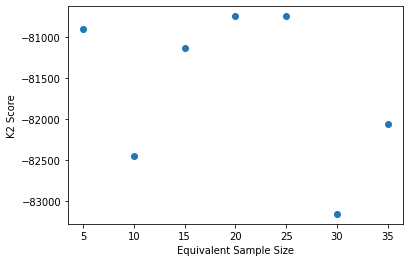

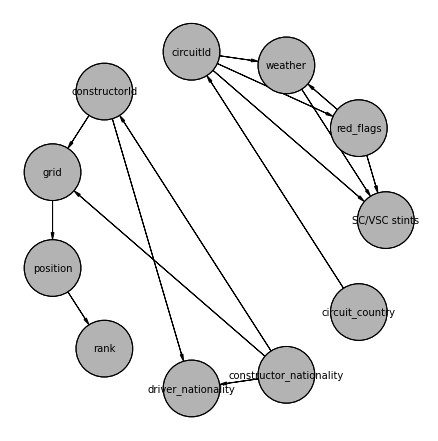

In [6]:
print("Choosing the best DAG based on the K2 score:")

k2_score_list = []
dag_scorer = K2Score(data=data)

for i in range(len(dag_list)):
    k2_score_list.append(dag_scorer.score(dag_list[i]))
    
k2_best_index = k2_score_list.index(max(k2_score_list))
print(f"Best ESS: {ess_list[k2_best_index]}")
print(f"Best score: {k2_score_list[k2_best_index]}")

plt.scatter(ess_list, k2_score_list)
plt.xlabel("Equivalent Sample Size")
plt.ylabel("K2 Score")
plt.show()

plot_model(dag_list[k2_best_index])

In [7]:
# Select the DAG structure with the best K2 score:
dag = dag_list[k2_best_index]
ess = ess_list[k2_best_index]

## 3. Learning the parameters of the model

In [8]:
# The BayesianEstimator class computes parameters for a model using Bayesian Parameter Estimation.
model = BayesianModel(dag.edges())
model.fit(data, estimator=BayesianEstimator, prior_type="BDeu", equivalent_sample_size=ess)
model.check_model()

True

In [9]:
# CPT
print("Conditional Probability Table of node 'rank':")
print(model.get_cpds('rank'))

Conditional Probability Table of node 'rank':
+----------------------+----------------------+--------------------------+-----------------------+------------------------+-----------------------+-----------------------+-----------------------+
| position             | position(DNF)        | position(last positions) | position(podium)      | position(top-fifteen)  | position(top-five)    | position(top-ten)     | position(winner)      |
+----------------------+----------------------+--------------------------+-----------------------+------------------------+-----------------------+-----------------------+-----------------------+
| rank(fastest lap)    | 0.004163133143165522 | 0.006115169016476981     | 0.14791302364479586   | 0.011248844842420572   | 0.10320839352239032   | 0.024278375733855186  | 0.2942600015125161    |
+----------------------+----------------------+--------------------------+-----------------------+------------------------+-----------------------+-----------------------

## 4. Analysis of the DAG structure

In [10]:
# Roots
print("Roots:")
print(model.get_roots())
print()

# Leaves
print("Leaves:")
print(model.get_leaves())
print()

# Children
print("Children of node 'constructor_nationality':")
print(model.get_children("constructor_nationality"))
print()

# Predecessors
print("Predecessors of node 'grid':")
print(list(model.predecessors("grid")))
print()

# Successors
print("Successors of node 'grid':")
print(list(model.successors("grid")))
print()

# Markov Blanket
print("Markov Blanket of node 'constructorId':")
print(model.get_markov_blanket("constructorId"))
print()

# Local Independencies
print("Local independencies of node 'red_flags':")
print(model.local_independencies("red_flags"))
print()

# Active Trails
print("Active trails for node 'weather' given 'circuit_country':")
print(model.active_trail_nodes("weather", observed=["circuit_country"]))
print()
print("Active trails for node 'rank' given 'driver_nationality':")
print(model.active_trail_nodes("rank", observed=["driver_nationality"]))

Roots:
['constructor_nationality', 'circuit_country']

Leaves:
['SC/VSC stints', 'driver_nationality', 'rank']

Children of node 'constructor_nationality':
['constructorId', 'driver_nationality', 'grid']

Predecessors of node 'grid':
['constructorId', 'constructor_nationality']

Successors of node 'grid':
['position']

Markov Blanket of node 'constructorId':
['grid', 'driver_nationality', 'constructor_nationality']

Local independencies of node 'red_flags':
(red_flags ⟂ driver_nationality, grid, position, circuit_country, constructorId, constructor_nationality, rank | circuitId)

Active trails for node 'weather' given 'circuit_country':
{'weather': {'weather', 'SC/VSC stints', 'circuitId', 'red_flags'}}

Active trails for node 'rank' given 'driver_nationality':
{'rank': {'grid', 'position', 'constructorId', 'constructor_nationality', 'rank'}}


## 5. Exact inference with Variable Elimination

In [11]:
inference = VariableElimination(model)

def plot_query_results(title, model, query_var, evidence):
    results = inference.query(variables = [query_var], evidence = evidence, show_progress=False)
    
    fig = plt.figure()
    plt.bar(results.state_names[query_var],results.values)
    plt.xticks(results.state_names[query_var], rotation=60)
    plt.title(title)
    plt.ylim(bottom=0.0, top=1.0)
    plt.show()

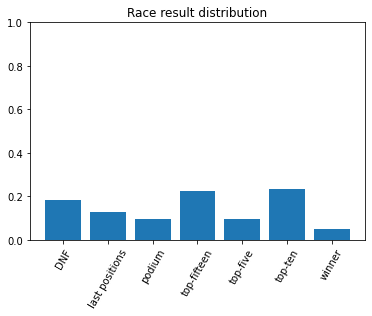

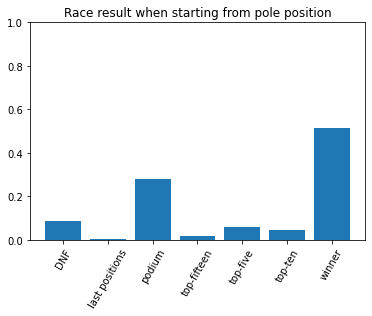

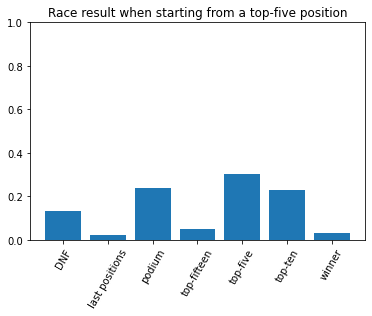

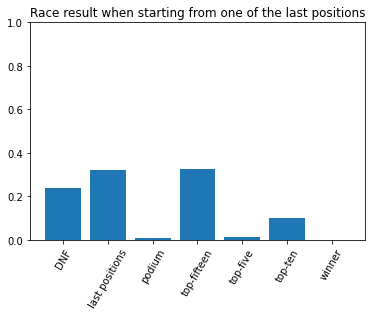

In [12]:
# How strong is the relationship between the starting and the ending positions in a race?
plot_query_results('Race result distribution', model, 'position', {})
plot_query_results('Race result when starting from pole position', model, 'position', {'grid': 'pole'})
plot_query_results('Race result when starting from a top-five position', model, 'position', {'grid': 'top-five'})
plot_query_results('Race result when starting from one of the last positions', model, 'position', {'grid': 'last positions'})

In [13]:
# What will most likely happen in a race held in Belgium in varied weather?
print(inference.map_query(variables=['red_flags', 'SC/VSC stints'],
                          evidence={'circuit_country': 'Belgium', 'weather': 'Varied'},
                          show_progress=False))

{'red_flags': 'No', 'SC/VSC stints': 2}


In [14]:
# What constructor is more likely to have at least a car not being able to finish the race?
print(inference.map_query(variables=['constructorId'], evidence={'position' : 'DNF'}, show_progress=False))

# What constructor is more likely to obtain the fastest lap of the race?
print(inference.map_query(variables=['constructorId'], evidence={'rank' : 'fastest lap'}, show_progress=False))

# What circuit is more likely not to be hit by rain for the entire duration of the race?
print(inference.map_query(variables=['circuitId'], evidence={'weather' : 'Dry'}, show_progress=False))

{'constructorId': 5}
{'constructorId': 11}
{'circuitId': 4}
